In [2]:
from Modular_code.utils import *
from Modular_code.model import Model
from Modular_code.train import train_epoch
from Modular_code.val import val_epoch
from Modular_code.opts import *
from Modular_code.clr import OneCycle
from Modular_code.radam import RAdam

/home/sanjaymoto75/.conda/envs/env/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
import pandas as pd
train_label = pd.read_csv(train_label_path)
valid_label = pd.read_csv(valid_label_path)
test_label = pd.read_csv(test_label_path)

In [4]:
train_id,train_classes = create_label(train_label,'./DataSet/Train') 
test_id,test_classes = create_label(test_label,'./DataSet/Test') 
valid_id,valid_classes = create_label(valid_label,'./DataSet/Validation') 

In [5]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2

class video_dataset(Dataset):
    def __init__(self,id,label,sequence_length = 60,transform = None):
        self.id =id
        self.engagement = label
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.id)-self.count
    def __getitem__(self,idx):
        video_path = self.id[idx]
        frames = []
        a = int(300/self.count)
        for frame in frame_extract(video_path):
            frames.append(self.transform(frame))
        frames = torch.stack(frames)
        frames = frames[::a,:,:,:]
        frames = frames[:self.count]
        frames = frames.reshape(self.count,3,im_size,im_size)
        label = self.engagement[idx]
        return frames,label

In [6]:
train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

train_data = video_dataset(train_id,train_classes,sequence_length = 150,transform = train_transforms)
val_data = video_dataset(valid_id,valid_classes,sequence_length = 150,transform = train_transforms)
test_data = video_dataset(test_id,test_classes,sequence_length = 150,transform = train_transforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


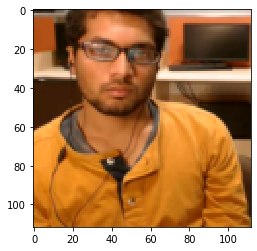

In [7]:
import cv2
import random
image,_ = train_data[3900]
im_plot(image[10,:,:,:])

In [8]:
model = nn.DataParallel(Model().to('cuda'))
num_epochs = 20
arch = 'dense121-150'
result_path = os.path.join('./results',arch)
lr = 5e-3

In [9]:
from tensorboardX import SummaryWriter
writer = SummaryWriter()
os.makedirs(result_path,exist_ok = True)
train_logger = Logger(
            os.path.join(result_path, 'train{}.log'.format(arch)),
            ['epoch', 'loss', 'acc', 'lr'])
train_batch_logger = Logger(
            os.path.join(result_path, 'train_batch{}.log'.format(arch)),
            ['epoch', 'batch', 'iter', 'loss', 'acc', 'lr'])    
val_logger = Logger(
            os.path.join(result_path, 'val{}.log'.format(arch)), ['epoch', 'loss', 'acc'])

In [10]:
train_loader = DataLoader(train_data,batch_size = 8 , num_workers = 12 ,shuffle = True)
val_loader = DataLoader(val_data,batch_size = 8 , num_workers = 12 )
test_loader = DataLoader(test_data,batch_size = 8 , num_workers = 12)

In [ ]:
optimizer = RAdam(model.parameters(), lr= lr,weight_decay = 1e-3)
onecyc = OneCycle(len(train_loader)*num_epochs, lr)
n_epochs = num_epochs
for epoch in range(1,num_epochs):
    if(epoch%10==0 and epoch!=0):
        lr = 0.9*lr
        n_epochs = n_epochs-10
        onecyc = OneCycle(len(train_loader)*n_epochs,lr)
        update_lr(optimizer,lr)
    train_epoch(epoch, num_epochs,train_loader, model, criterion, optimizer, train_logger, train_batch_logger , 8 , onecyc , writer)
    val_epoch(epoch, num_epochs, valid_loader, model, criterion, val_logger , 8 ,writer)

Training Epoch 1

[Epoch 1/20] [Batch 170 / 651] [Time 2.13 2.30] [Data 0.02 0.07] [Loss: 1.044193, Acc: 48.10%]